In [1]:
import math
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit import QuantumCircuit, QuantumRegister, assemble, Aer
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, PhaseEstimation


Supongamos que queremos estimar las fases de los autovalores de la matriz U que definimos más abajo. Queremos medir con una 
precisión de n bits y probabilidad 1-epsilon, por lo que definimos t = n + E(log(2+1/(2epsilon)))

In [4]:
eps = 0.05
n = 4

t = n + math.trunc(math.log(2+1/(2*eps))) 
if math.log(2+1/(2*eps)) - math.trunc(math.log(2+1/(2*eps))) != 0:
    t = t+1

#Definimos U como el operador rotación theta
U = [[1,0,0,0],[0,1j,0,0],[0,0,-1,0],[0,0,0,-1j]]

m = int(math.log2(len(U)))


In [9]:
def multiplicar_matrices(matriz1, matriz2):
    filas_matriz1 = len(matriz1)
    columnas_matriz1 = len(matriz1[0])
    filas_matriz2 = len(matriz2)
    columnas_matriz2 = len(matriz2[0])
    resultado = [[0] * columnas_matriz2 for _ in range(filas_matriz1)]

    for i in range(filas_matriz1):
        for j in range(columnas_matriz2):
            for k in range(columnas_matriz1):
                resultado[i][j] += matriz1[i][k] * matriz2[k][j]

    return resultado
    
    
def exponenciar(m,exp):
    m_aux = m
    for i in range(exp-1):
        m_aux = multiplicar_matrices(m_aux,m)
    return m_aux

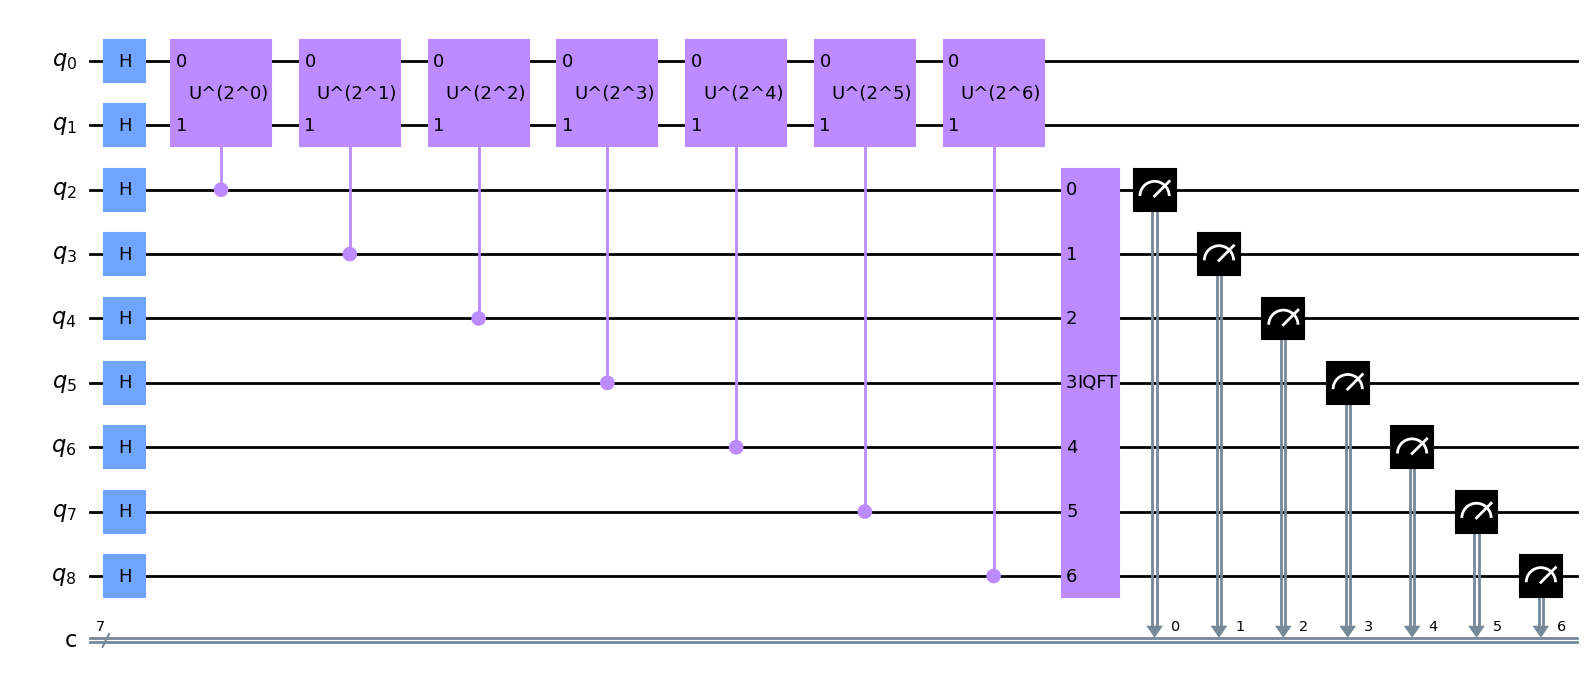

In [12]:
phase_circ = QuantumCircuit(t+m,t)

for i in range(t+m):
    phase_circ.h(i)

    
for i in range(t):
    cond_operator_U = exponenciar(U,2**i)
    partial_circ = QuantumCircuit(m, name="U^(2^"+str(i)+")")
    partial_circ.append(Operator(cond_operator_U),[i for i in range(m)])
    phase_circ.append(partial_circ.to_gate().control(1),[m+i]+[i for i in range(m)])

phase_circ.append(QFT(num_qubits=t, approximation_degree=0, do_swaps=True, inverse=True, insert_barriers=False, name=None),[i for i in range(m,t+m)])

for i in range(m,m+t):
    phase_circ.measure(i,i-m)
    
phase_circ.draw('mpl')

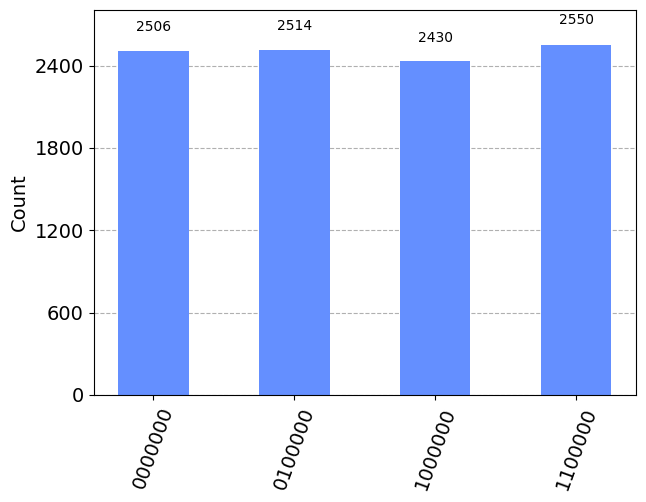

In [7]:
#Procedemos a compilar el circuito y ejecutarlo:
simulator = AerSimulator()
circuit_compiled = transpile(phase_circ,simulator)
trabajo_sim = simulator.run(circuit_compiled, shots = 10000)
result = trabajo_sim.result()
counts = result.get_counts(circuit_compiled)

plot_histogram(counts)


Como hemos discutido en el estudio teórico de este algoritmo, al medir obtenemos con las dos fases posibles de los autovectores 
de este operador, que son 0.000000 (e^(0)=1),0.100000 (e^(iPI)= -1),0.010000 = 1/4 (e^(iPI/2) = i) y 0.110000 (e^(iPI3/2 = -i). 